In [1]:
!pip install -q rpy2

# Poisson Regression Workflow

## Python Imports

In [2]:
import os
import warnings
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, poisson
from scipy.special import gammaln
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
from rpy2.robjects.lib import grdevices
import rpy2.ipython.html

# Suppress warnings from rpy2
warnings.filterwarnings("ignore", category=FutureWarning, module="rpy2")
# Disable R warnings
rpy2_logger.setLevel(50)
# Enable R printing
rpy2.ipython.html.init_printing()
# Enable automatic DataFrame conversion
pandas2ri.activate()

## R Package Installation

In [3]:
# Function to install R packages if not already installed
def install_if_needed(package_name):
    try:
        importr(package_name)
    except PackageNotInstalledError:
        print(f"Installing {package_name}...")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
        with contextlib.redirect_stdout(None):
            utils.install_packages(package_name, quiet=True)

# Install required R packages
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
with contextlib.redirect_stdout(None):
    install_if_needed('stats')
    install_if_needed('ggplot2')
    install_if_needed('performance')

## Generate the Data

In [4]:
# Generate data with Poisson-distributed response variable
np.random.seed(0)
X = np.random.rand(1000, 3)
y = np.random.poisson(np.exp(1 + X[:, 0] + X[:, 1] - X[:, 2]))

# Create a DataFrame
data = pd.DataFrame(np.column_stack((X, y)), columns=['X1', 'X2', 'X3', 'y'])
print(data.head())

# Print information about the data
print("Data information:")
print(data.info())

         X1        X2        X3     y
0  0.548814  0.715189  0.602763   7.0
1  0.544883  0.423655  0.645894   2.0
2  0.437587  0.891773  0.963663   4.0
3  0.383442  0.791725  0.528895  10.0
4  0.568045  0.925597  0.071036   6.0
Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   X3      1000 non-null   float64
 3   y       1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB
None


## Prepare the Data

In [5]:
# Split the data into X and y
X = data[['X1', 'X2', 'X3']]
y = data['y']

# Print shape information
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 3)
y shape: (1000,)


## Statsmodels Workflow

In [6]:
# Fit the model
X_sm = sm.add_constant(X)
model_sm = sm.GLM(y, X_sm, family=sm.families.Poisson()).fit()

# Model summary
print("Model Summary:")
print(model_sm.summary())

Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      996
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2096.5
Date:                Mon, 22 Jul 2024   Deviance:                       1009.1
Time:                        02:32:27   Pearson chi2:                     953.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.7030
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9858      0.048     

In [7]:
# Get predictions
y_pred_sm = model_sm.predict(X_sm)

# Get metrics
mse_sm = mean_squared_error(y, y_pred_sm)
rmse_sm = np.sqrt(mse_sm)

aic_sm = model_sm.aic
bic_sm = model_sm.bic_llf

dev_sm = model_sm.deviance

K_sm = len(model_sm.params) - 1

ll_mod_sm = model_sm.llf
ll_null_sm = model_sm.llnull

mcf_r2_sm = model_sm.pseudo_rsquared(kind='mcf')
mcf_r2_adj_sm = 1 - ((ll_mod_sm - K_sm) / ll_null_sm)

In [8]:
# Create metrics DataFrame
metrics_df_sm = pd.DataFrame({
    'Metric': [
        'MSE', 'RMSE',
        'AIC', 'BIC',
        'Dev', 'LL', 'LL_0',
        'McF_R2', 'McF_R2_Adj'
    ],
    'Value': [
        mse_sm, rmse_sm,
        aic_sm, bic_sm,
        dev_sm, ll_mod_sm, ll_null_sm,
        mcf_r2_sm, mcf_r2_adj_sm
    ]
})

print("Metrics DataFrame:")
print(metrics_df_sm)

Metrics DataFrame:
       Metric        Value
0         MSE     4.583458
1        RMSE     2.140901
2         AIC  4200.936760
3         BIC  4220.567782
4         Dev  1009.067755
5          LL -2096.468380
6        LL_0 -2703.457066
7      McF_R2     0.224523
8  McF_R2_Adj     0.223413


## Sklearn Workflow

In [9]:
# Set model arguments
fit_intercept = True
solver = 'lbfgs'
max_iter = 3000
tol = 1e-9
warm_start = True

# Parameter distributions
param_distributions = {
    'alpha': uniform(loc=0.0, scale=0.1)
}

# Fit the estimator
model_sk = PoissonRegressor(
    fit_intercept=fit_intercept,
    solver=solver,
    max_iter=max_iter,
    tol=tol,
    warm_start=warm_start
)
model_sk.fit(X, y)

PoissonRegressor(max_iter=3000, tol=1e-09, warm_start=True)

In [10]:
# Run the search
search = HalvingRandomSearchCV(
    estimator=model_sk,
    param_distributions=param_distributions,
    n_candidates='exhaust',
    factor=3,
    cv=10,
    resource='n_samples',
    max_resources='auto',
    random_state=0,
    scoring='neg_mean_squared_error'
).fit(X, y)

# Search results
best_params_sk = search.best_params_
best_score_sk = -search.best_score_
print("Best Parameters:", best_params_sk)
print("Best Score:", best_score_sk)

Best Parameters: {'alpha': 0.04561503322165486}
Best Score: 5.319544111872482


In [11]:
# Refit with best parameters
model_sk_final = PoissonRegressor(
    **best_params_sk,
    fit_intercept=fit_intercept,
    solver=solver,
    max_iter=max_iter,
    tol=tol,
    warm_start=warm_start
)
model_sk_final.fit(X, y)

PoissonRegressor(alpha=0.04561503322165486, max_iter=3000, tol=1e-09,
                 warm_start=True)

In [12]:
# Get predictions
y_pred_sk = model_sk_final.predict(X)

# Get metrics
mse_sk = mean_squared_error(y, y_pred_sk)
rmse_sk = np.sqrt(mse_sk)

In [13]:
# Statistical utility functions
def poisson_log_likelihood(y, mu, weights=None):
    """Calculate the log-likelihood of a Poisson GLM with log link."""
    y = np.asarray(y)
    mu = np.asarray(mu)

    # Check if weights are provided, and if not, assign equal weights of 1
    if weights is None:
        weights = np.ones_like(y)

    # Calculate the log-likelihood
    log_likelihood = np.sum(weights * (y * np.log(mu) - mu - gammaln(y + 1)))

    return log_likelihood

def calculate_aic_bic(log_likelihood, n_obs, n_params):
    """Calculate AIC and BIC for the model."""
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_obs)
    return aic, bic

def fit_null_model(y, params):
    """Fit a null Poisson regression model with only an intercept."""
    null_model = PoissonRegressor(
        **params,
        fit_intercept=fit_intercept,
        solver=solver,
        max_iter=max_iter,
        tol=tol,
        warm_start=warm_start
    )
    null_model.fit(np.ones((len(y), 1)), y)
    y_pred_null = null_model.predict(np.ones((len(y), 1)))
    return null_model, y_pred_null

def calculate_mcfadden_r2(ll_model, ll_null, model):
    """Calculate McFadden's Pseudo R-squared and its adjusted version."""
    mcf_r2 = 1 - (ll_model / ll_null)
    K = len(model.coef_)
    mcf_r2_adj = 1 - ((ll_model - K) / ll_null)
    return mcf_r2, mcf_r2_adj, K

def calculate_deviance(y, y_pred, freq_weights=1.0, var_weights=1.0, scale=1.0):
    """Calculate the deviance for Poisson regression."""
    poisson_family = sm.families.Poisson()
    resid_dev = poisson_family._resid_dev(y, y_pred)
    deviance = np.sum(resid_dev * freq_weights * var_weights / scale)
    return deviance

In [14]:
# Calculate log-likelihood for the full model
ll_mod_sk = poisson_log_likelihood(y, y_pred_sk)

# Calculate the AIC and BIC for the full model
n_obs = len(y)
n_params = len(model_sk_final.coef_) + 1  # Include the intercept
aic_sk, bic_sk = calculate_aic_bic(ll_mod_sk, n_obs, n_params)

# Fit the null model and get its predictions
null_model_sk, y_pred_null_sk = fit_null_model(y, best_params_sk)

# Calculate log-likelihood for the null model
ll_null_sk = poisson_log_likelihood(y, y_pred_null_sk)

# Calculate McFadden's Pseudo R2 and adjusted version
mcf_r2_sk, mcf_r2_adj_sk, K_sk = calculate_mcfadden_r2(ll_mod_sk, ll_null_sk, model_sk_final)

# Calculate deviance
dev_sk = calculate_deviance(y, y_pred_sk)

In [15]:
# Print parameters
print("Intercept:")
print(model_sk_final.intercept_)

print("\nCoefficients:")
print(model_sk_final.coef_)

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'variables': X.columns,
    'param': model_sk_final.coef_.flatten().round(4)
})

# Create a DataFrame for intercept
intercept_df = pd.DataFrame([['Intercept', round(model_sk_final.intercept_, 4)]], columns=['variables', 'param'])

# Combine intercept and coefficients DataFrames
params_df = pd.concat([intercept_df, coef_df], ignore_index=True)

# Print the combined DataFrame
print("\nParameters DataFrame:")
print(params_df)

Intercept:
1.0536329467263272

Coefficients:
[ 0.91303709  0.87946521 -0.92790611]

Parameters DataFrame:
   variables   param
0  Intercept  1.0536
1         X1  0.9130
2         X2  0.8795
3         X3 -0.9279


In [16]:
# Create metrics DataFrame
metrics_df_sk = pd.DataFrame({
    'Metric': [
        'MSE', 'RMSE',
        'AIC', 'BIC',
        'Dev', 'LL', 'LL_0',
        'McF_R2', 'McF_R2_Adj'
    ],
    'Value': [
        mse_sk, rmse_sk,
        aic_sk, bic_sk,
        dev_sk, ll_mod_sk, ll_null_sk,
        mcf_r2_sk, mcf_r2_adj_sk
    ]
})

print("Metrics DataFrame:")
print(metrics_df_sk)

Metrics DataFrame:
       Metric        Value
0         MSE     4.690424
1        RMSE     2.165739
2         AIC  4214.059473
3         BIC  4233.690494
4         Dev  1022.190467
5          LL -2103.029736
6        LL_0 -2703.457066
7      McF_R2     0.222096
8  McF_R2_Adj     0.220986


## R Workflow

In [17]:
# Convert to R DataFrame
r_data = ro.DataFrame(data)

# Add to global environment
ro.globalenv['r_data'] = r_data

# R script
r_code = '''

# Load packages
library(stats)
library(ggplot2)
library(performance)

# Fit the model
model <- glm(y ~ X1 + X2 + X3, data=r_data, family=poisson(link="log"))

# Model summary
cat("Model Summary:\n")
print(summary(model))

# Get predictions
y_pred <- predict(model, newdata=r_data, type="response")

# Get metrics
mse <- mean((r_data$y - y_pred)^2)
rmse <- sqrt(mse)

aic <- AIC(model)
bic <- BIC(model)

null_model <- glm(y ~ 1, data=r_data, family=poisson(link="log"))
K <- length(insight::find_parameters(model)$conditional) - 1

ll_mod <- logLik(model)
ll_null <- logLik(null_model)

mcf_r2 <- 1 - (ll_mod / ll_null)
mcf_r2_adj <- 1 - ((ll_mod - K) / ll_null)

dev <- deviance(model)

# Use performance package to compare results
mcf_r2_perf <- performance::r2_mcfadden(model)

# Examine the output structure
cat("\nStructure of performance package output:\n")
str(mcf_r2_perf)

# Examine model parameters
cat("\nModel parameters:\n")
print(insight::find_parameters(model))

# Use performance package to compare results
cat("\nPerformance package LL:\n")
print(insight::get_loglikelihood(model))

# Create a list of results
list(
    mse=mse,
    rmse=rmse,
    aic=aic,
    bic=bic,
    K=K,
    ll_mod=ll_mod,
    ll_null=ll_null,
    mcf_r2=mcf_r2,
    mcf_r2_adj=mcf_r2_adj,
    dev=dev,
    mcf_r2_perf=mcf_r2_perf$R2,
    mcf_r2_adj_perf=mcf_r2_perf$R2_adjusted
)
'''

# Execute the R code and get the results
result = ro.r(r_code)

Model Summary:

Call:
glm(formula = y ~ X1 + X2 + X3, family = poisson(link = "log"), 
    data = r_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.98580    0.04757   20.72   <2e-16 ***
X1           1.01842    0.04952   20.57   <2e-16 ***
X2           0.97633    0.04975   19.62   <2e-16 ***
X3          -1.04271    0.05077  -20.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2223.0  on 999  degrees of freedom
Residual deviance: 1009.1  on 996  degrees of freedom
AIC: 4200.9

Number of Fisher Scoring iterations: 4


Structure of performance package output:
List of 2
 $ R2         : Named num 0.225
  ..- attr(*, "names")= chr "McFadden's R2"
 $ R2_adjusted: Named num 0.224
  ..- attr(*, "names")= chr "adjusted McFadden's R2"
 - attr(*, "model_type")= chr "Generalized Linear"
 - attr(*, "class")= chr "r2_generic"

Model parameters:
$condit

In [18]:
# Extract values from the result
mse_r = result.rx2('mse')[0]
rmse_r = result.rx2('rmse')[0]

aic_r = result.rx2('aic')[0]
bic_r = result.rx2('bic')[0]

K_r = result.rx2('K')[0]

ll_mod_r = result.rx2('ll_mod')[0]
ll_null_r = result.rx2('ll_null')[0]

mcf_r2_r = result.rx2('mcf_r2')[0]
mcf_r2_adj_r = result.rx2('mcf_r2_adj')[0]

dev_r = result.rx2('dev')[0]

mcf_r2_perf = result.rx2('mcf_r2_perf')[0]
mcf_r2_adj_perf = result.rx2('mcf_r2_adj_perf')[0]

In [19]:
# Compare McFadden's R2 calculations
print("McF R2 & adjusted R2 manual calculation:")
print(mcf_r2_r)
print(mcf_r2_adj_r)

print("\nMcF R2 & adjusted R2 performance calculation:")
print(mcf_r2_perf)
print(mcf_r2_adj_perf)

McF R2 & adjusted R2 manual calculation:
0.22452314620808433
0.22341345593881423

McF R2 & adjusted R2 performance calculation:
0.22452314620808433
0.22415324945166093


In [20]:
# Create metrics DataFrame
metrics_df_r = pd.DataFrame({
    'Metric': [
        'MSE', 'RMSE',
        'AIC', 'BIC',
        'Dev', 'LL', 'LL_0',
        'McF_R2', 'McF_R2_Adj'
    ],
    'Value': [
        mse_r, rmse_r,
        aic_r, bic_r,
        dev_r, ll_mod_r, ll_null_r,
        mcf_r2_r, mcf_r2_adj_r
    ]
})

print("Metrics DataFrame:")
print(metrics_df_r)

Metrics DataFrame:
       Metric        Value
0         MSE     4.583458
1        RMSE     2.140901
2         AIC  4200.936760
3         BIC  4220.567782
4         Dev  1009.067755
5          LL -2096.468380
6        LL_0 -2703.457066
7      McF_R2     0.224523
8  McF_R2_Adj     0.223413


## Compare the Results

In [21]:
# Create log-likelihood DataFrame
ll_df = pd.DataFrame({
    'SM': [ll_mod_sm, ll_null_sm, K_sm],
    'SKL': [ll_mod_sk, ll_null_sk, K_sk],
    'R': [ll_mod_r, ll_null_r, K_r]
}, index=['LL', 'LL_0', 'K'])

print("Log-Likelihood DataFrame:")
print(ll_df)

Log-Likelihood DataFrame:
               SM          SKL            R
LL   -2096.468380 -2103.029736 -2096.468380
LL_0 -2703.457066 -2703.457066 -2703.457066
K        3.000000     3.000000     3.000000


In [22]:
# Create model metrics DataFrame
metrics_df = pd.DataFrame({
    'SM': [
        mse_sm, rmse_sm,
        aic_sm, bic_sm,
        dev_sm, ll_mod_sm, ll_null_sm,
        mcf_r2_sm, mcf_r2_adj_sm
    ],
    'SKL': [
        mse_sk, rmse_sk,
        aic_sk, bic_sk,
        dev_sk, ll_mod_sk, ll_null_sk,
        mcf_r2_sk, mcf_r2_adj_sk
    ],
    'R': [
        mse_r, rmse_r,
        aic_r, bic_r,
        dev_r, ll_mod_r, ll_null_r,
        mcf_r2_r, mcf_r2_adj_r
    ]
}, index=[
    'MSE', 'RMSE',
    'AIC', 'BIC',
    'Dev', 'LL', 'LL_0',
    'McF_R2', 'McF_R2_Adj'
])

print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
                     SM          SKL            R
MSE            4.583458     4.690424     4.583458
RMSE           2.140901     2.165739     2.140901
AIC         4200.936760  4214.059473  4200.936760
BIC         4220.567782  4233.690494  4220.567782
Dev         1009.067755  1022.190467  1009.067755
LL         -2096.468380 -2103.029736 -2096.468380
LL_0       -2703.457066 -2703.457066 -2703.457066
McF_R2         0.224523     0.222096     0.224523
McF_R2_Adj     0.223413     0.220986     0.223413


In [23]:
# Reverse signs of LL and LL_0 and rename to Neg_LL and Neg_LL_0
metrics_df_nll = metrics_df.copy()
metrics_df_nll.loc['Neg_LL'] = -metrics_df_nll.loc['LL']
metrics_df_nll.loc['Neg_LL_0'] = -metrics_df_nll.loc['LL_0']
metrics_df_nll = metrics_df_nll.drop(['LL', 'LL_0'])

# Re-order the indices
metrics_df_nll = metrics_df_nll.loc[[
    'MSE', 'RMSE', 'AIC', 'BIC', 'Dev', 'Neg_LL', 'Neg_LL_0', 'McF_R2', 'McF_R2_Adj'
]]

print("Modified Metrics DataFrame:")
print(metrics_df_nll)

Modified Metrics DataFrame:
                     SM          SKL            R
MSE            4.583458     4.690424     4.583458
RMSE           2.140901     2.165739     2.140901
AIC         4200.936760  4214.059473  4200.936760
BIC         4220.567782  4233.690494  4220.567782
Dev         1009.067755  1022.190467  1009.067755
Neg_LL      2096.468380  2103.029736  2096.468380
Neg_LL_0    2703.457066  2703.457066  2703.457066
McF_R2         0.224523     0.222096     0.224523
McF_R2_Adj     0.223413     0.220986     0.223413


In [24]:
# Define the colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Create list of metric groups
metric_groups = [
    ['MSE', 'RMSE'],
    ['AIC', 'BIC'],
    ['Dev', 'Neg_LL', 'Neg_LL_0'],
    ['McF_R2', 'McF_R2_Adj']
]

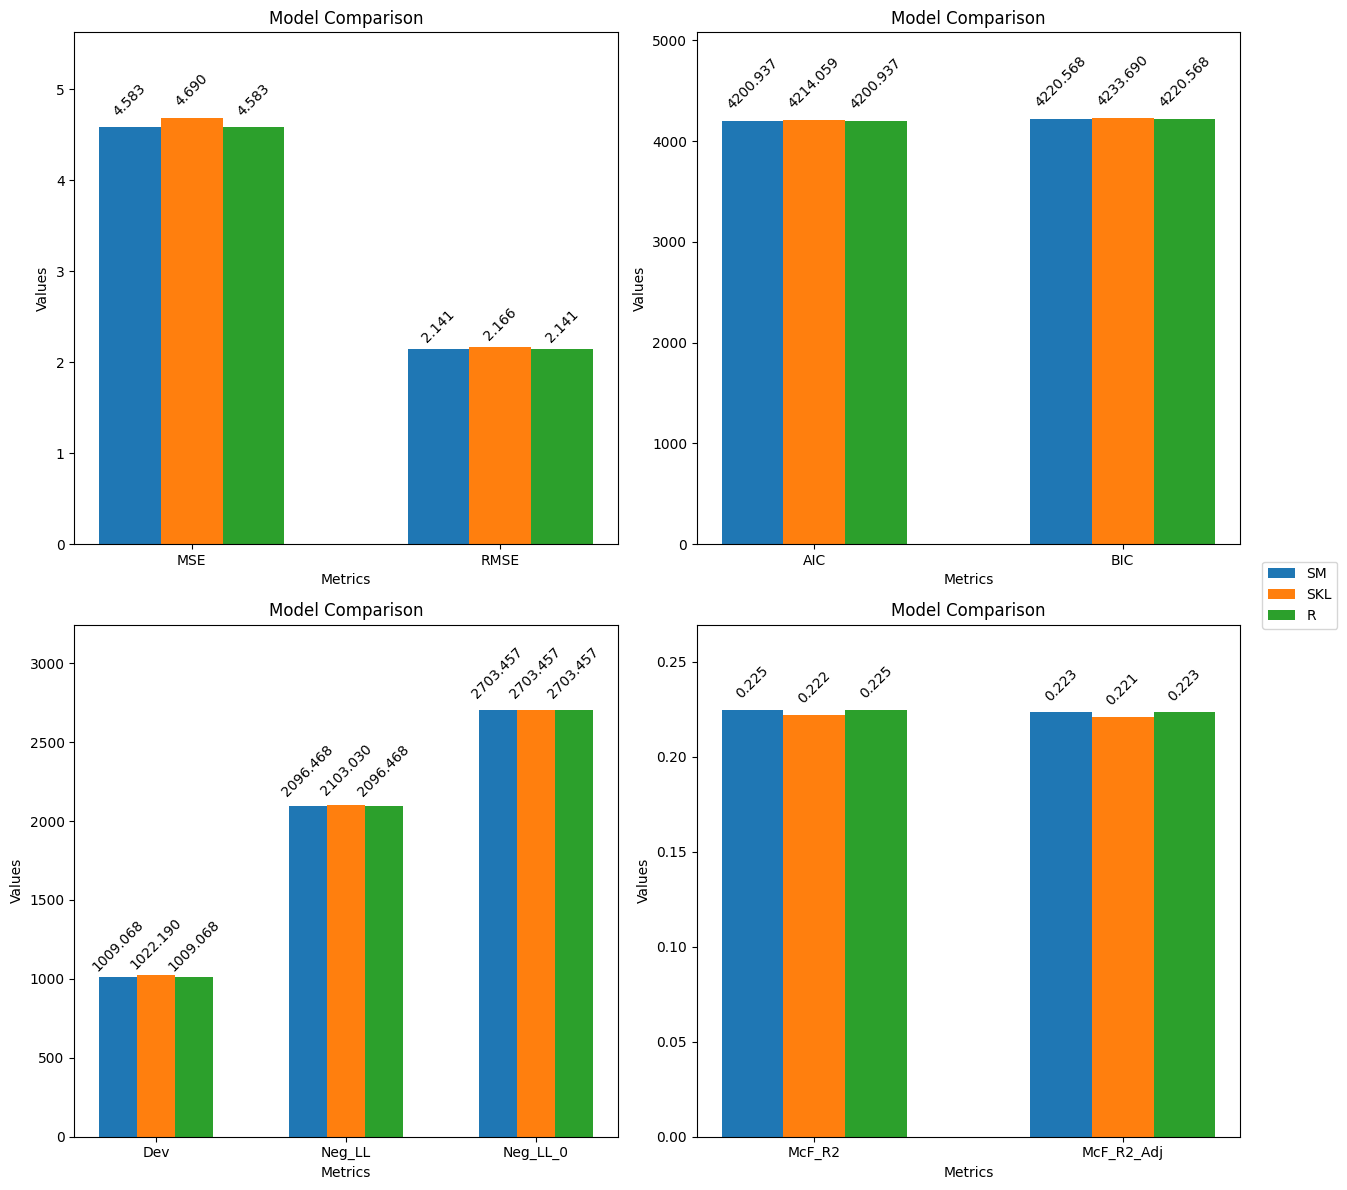

In [25]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# Plot each group of metrics in a separate subplot
for ax, metric_group in zip(axes, metric_groups):
    bar_width = 0.2
    index = np.arange(len(metric_group))

    for i, model in enumerate(metrics_df_nll.columns):
        bars = ax.bar(index + i * bar_width, metrics_df_nll.loc[metric_group, model],
                      bar_width, label=model, color=colors[i])

        # Add text annotations
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.02 * height,
                    f'{height:.3f}', ha='center', va='bottom', rotation=45, fontsize=10)

    # Extend y-axis limits slightly for each subplot
    y_max = max(metrics_df_nll.loc[metric_group].max()) * 1.2
    ax.set_ylim(0, y_max)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Comparison')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(metric_group)

# Set up legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

# Logistic Regression Workflow

## Python Imports

In [26]:
import os
import warnings
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, roc_curve
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform
from scipy.special import gammaln, logit, expit
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
from rpy2.robjects.lib import grdevices
import rpy2.ipython.html

# Suppress warnings from rpy2
warnings.filterwarnings("ignore", category=FutureWarning, module="rpy2")
# Disable R warnings
rpy2_logger.setLevel(50)
# Enable R printing
rpy2.ipython.html.init_printing()
# Enable automatic DataFrame conversion
pandas2ri.activate()

## R Package Installation

In [27]:
# Function to install R packages if not already installed
def install_if_needed(package_name):
    try:
        importr(package_name)
    except PackageNotInstalledError:
        print(f"Installing {package_name}...")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
        with contextlib.redirect_stdout(None):
            utils.install_packages(package_name, quiet=True)

# Install required R packages
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
with contextlib.redirect_stdout(None):
    install_if_needed('stats')
    install_if_needed('ggplot2')
    install_if_needed('performance')
    install_if_needed('pROC')

## Generate the Data

In [28]:
# Generate data with binary response variable
np.random.seed(0)
X = np.random.rand(1000, 3)
y = np.random.binomial(1, np.exp(1 + X[:, 0] - X[:, 1] + X[:, 2]) / (1 + np.exp(1 + X[:, 0] - X[:, 1] + X[:, 2])))

# Create a DataFrame
data = pd.DataFrame(np.column_stack((X, y)), columns=['X1', 'X2', 'X3', 'y'])
print(data.head())

# Print information about the data
print("Data information:")
print(data.info())

         X1        X2        X3    y
0  0.548814  0.715189  0.602763  1.0
1  0.544883  0.423655  0.645894  1.0
2  0.437587  0.891773  0.963663  1.0
3  0.383442  0.791725  0.528895  0.0
4  0.568045  0.925597  0.071036  0.0
Data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   X3      1000 non-null   float64
 3   y       1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB
None


## Prepare the Data

In [29]:
# Split the data into X and y
X = data[['X1', 'X2', 'X3']]
y = data['y']

# Print shape information
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1000, 3)
y shape: (1000,)


## Statsmodels Workflow

In [30]:
# Fit the model
X_sm = sm.add_constant(X)
model_sm = sm.GLM(y, X_sm, family=sm.families.Binomial()).fit()

# Model summary
print("Model Summary:")
print(model_sm.summary())

Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -448.00
Date:                Mon, 22 Jul 2024   Deviance:                       895.99
Time:                        02:33:10   Pearson chi2:                     997.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04572
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8155      0.248     

In [31]:
# Get predictions
y_pred_proba_sm = model_sm.predict(X_sm)
y_pred_binary_sm = (y_pred_proba_sm >= 0.5).astype(int)

# Get metrics
accuracy_sm = accuracy_score(y, y_pred_binary_sm)
auc_sm = roc_auc_score(y, y_pred_proba_sm)
precision_sm = precision_score(y, y_pred_binary_sm)
recall_sm = recall_score(y, y_pred_binary_sm)
f1_sm = f1_score(y, y_pred_binary_sm)

aic_sm = model_sm.aic
bic_sm = model_sm.bic_llf

K_sm = len(model_sm.params) - 1

ll_mod_sm = model_sm.llf
ll_null_sm = model_sm.llnull

mcf_r2_sm = model_sm.pseudo_rsquared(kind='mcf')
mcf_r2_adj_sm = 1 - ((ll_mod_sm - K_sm) / ll_null_sm)

dev_sm = model_sm.deviance

In [32]:
# Create metrics DataFrame
metrics_df_sm = pd.DataFrame({
    'Metric': [
        'Accuracy', 'AUC', 'Precision', 'Recall', 'F1',
        'AIC', 'BIC',
        'Dev', 'LL', 'LL_0',
        'McF_R2', 'McF_R2_Adj'
    ],
    'Value': [
        accuracy_sm, auc_sm, precision_sm, recall_sm, f1_sm,
        aic_sm, bic_sm,
        dev_sm, ll_mod_sm, ll_null_sm,
        mcf_r2_sm, mcf_r2_adj_sm
    ]
})

print("Metrics DataFrame:")
print(metrics_df_sm)

Metrics DataFrame:
        Metric       Value
0     Accuracy    0.820000
1          AUC    0.663564
2    Precision    0.820000
3       Recall    1.000000
4           F1    0.901099
5          AIC  903.993536
6          BIC  923.624557
7          Dev  895.993536
8           LL -447.996768
9         LL_0 -471.393487
10      McF_R2    0.049633
11  McF_R2_Adj    0.043269


## Sklearn Workflow

In [33]:
# Set model arguments
fit_intercept = True
solver = 'lbfgs'
max_iter = 3000
tol = 1e-9
warm_start = True

# Parameter distributions
param_distributions = [
    {'penalty': [None], 'C': [1.0]},  # No regularization, 'C' is not used but needs a placeholder
    {'penalty': ['l2'], 'C': uniform(0.01, 10)}  # L2 regularization with a uniform distribution for 'C'
]

# Fit the estimator
model_sk = LogisticRegression(
    fit_intercept=fit_intercept,
    solver=solver,
    max_iter=max_iter,
    tol=tol,
    warm_start=warm_start
)
model_sk.fit(X, y)

LogisticRegression(max_iter=3000, tol=1e-09, warm_start=True)

In [34]:
# Run the search
search = HalvingRandomSearchCV(
    estimator=model_sk,
    param_distributions=param_distributions,
    n_candidates='exhaust',
    factor=3,
    cv=10,
    resource='n_samples',
    max_resources='auto',
    random_state=0,
    scoring='accuracy'
).fit(X, y)

# Search results
best_params_sk = search.best_params_
best_score_sk = search.best_score_
print("Best Parameters:", best_params_sk)
print("Best Score:", best_score_sk)

Best Parameters: {'C': 3.3839616041726837, 'penalty': 'l2'}
Best Score: 0.8055555555555556


In [35]:
# Refit with best parameters
model_sk_final = LogisticRegression(
    **best_params_sk,
    fit_intercept=fit_intercept,
    solver=solver,
    max_iter=max_iter,
    tol=tol,
    warm_start=warm_start
)
model_sk_final.fit(X, y)

LogisticRegression(C=3.3839616041726837, max_iter=3000, tol=1e-09,
                   warm_start=True)

In [36]:
# Get predictions
y_pred_proba_sk = model_sk_final.predict_proba(X)[:, 1]
y_pred_binary_sk = (y_pred_proba_sk >= 0.5).astype(int)

# Get metrics
accuracy_sk = accuracy_score(y, y_pred_binary_sk)
auc_sk = roc_auc_score(y, y_pred_proba_sk)
precision_sk = precision_score(y, y_pred_binary_sk)
recall_sk = recall_score(y, y_pred_binary_sk)
f1_sk = f1_score(y, y_pred_binary_sk)

In [37]:
# Statistical utility functions
def logistic_log_likelihood(y, p, weights=None):
    """Calculate the log-likelihood of a logistic regression model."""
    if weights is None:
        weights = np.ones_like(y)

    # Clip probabilities to avoid log(0)
    eps = np.finfo(float).eps
    p = np.clip(p, eps, 1 - eps)

    # Number of trials for binomial distribution
    n = 1
    y_n = y * n

    # Compute the log-likelihood for each observation
    loglike_obs = (
        gammaln(n + 1) - gammaln(y_n + 1) - gammaln(n - y_n + 1) +
        y_n * np.log(p / (1 - p)) + n * np.log(1 - p)
    ) * weights

    log_likelihood = np.sum(loglike_obs)

    return log_likelihood

def calculate_aic_bic(log_likelihood, n_obs, n_params):
    """Calculate AIC and BIC for the model."""
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(n_obs)
    return aic, bic

def fit_null_model(y, params):
    """Fit a null Logistic regression model with only an intercept."""
    null_model = LogisticRegression(
        **params,
        fit_intercept=fit_intercept,
        solver=solver,
        max_iter=max_iter,
        tol=tol,
        warm_start=warm_start
    )
    X_null = np.ones((len(y), 1))
    null_model.fit(X_null, y)
    y_pred_proba_null = null_model.predict_proba(X_null)[:, 1]
    return null_model, y_pred_proba_null

def calculate_mcfadden_r2(ll_model, ll_null, model):
    """Calculate McFadden's Pseudo R-squared and its adjusted version."""
    mcf_r2 = 1 - (ll_model / ll_null)
    K = model.coef_.shape[1]
    mcf_r2_adj = 1 - ((ll_model - K) / ll_null)
    return mcf_r2, mcf_r2_adj, K

def calculate_deviance(y, y_pred, freq_weights=1.0, var_weights=1.0, scale=1.0):
    """Calculate the deviance for Logistic regression."""
    binomial_family = sm.families.Binomial()
    resid_dev = binomial_family._resid_dev(y, y_pred)
    deviance = np.sum(resid_dev * freq_weights * var_weights / scale)
    return deviance

In [38]:
# Calculate log-likelihood for the full model
ll_mod_sk = logistic_log_likelihood(y, y_pred_proba_sk)

# Calculate the AIC and BIC for the full model
n_obs = len(y)
n_params = model_sk_final.coef_.shape[1] + 1  # Include the intercept
aic_sk, bic_sk = calculate_aic_bic(ll_mod_sk, n_obs, n_params)

# Fit the null model and get its predicted probabilities
null_model_sk, y_pred_proba_null_sk = fit_null_model(y, best_params_sk)

# Calculate log-likelihood for the null model
ll_null_sk = logistic_log_likelihood(y, y_pred_proba_null_sk)

# Calculate McFadden's Pseudo R2 and adjusted R2
mcf_r2_sk, mcf_r2_adj_sk, K_sk = calculate_mcfadden_r2(ll_mod_sk, ll_null_sk, model_sk_final)

# Calculate deviance for the full model
dev_sk = calculate_deviance(y, y_pred_proba_sk)

In [39]:
# Print parameters
print("Intercept:")
print(model_sk_final.intercept_)

print("\nCoefficients:")
print(model_sk_final.coef_)

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'variables': X.columns,
    'param': model_sk_final.coef_.flatten().round(4)
})

# Create a DataFrame for intercept
intercept_df = pd.DataFrame([['Intercept', round(model_sk_final.intercept_[0], 4)]], columns=['variables', 'param'])

# Combine intercept and coefficients DataFrames
params_df = pd.concat([intercept_df, coef_df], ignore_index=True)

# Print the combined DataFrame
print("\nParameters DataFrame:")
print(params_df)

Intercept:
[0.82975921]

Coefficients:
[[ 1.25914292 -0.88308668  1.16256973]]

Parameters DataFrame:
   variables   param
0  Intercept  0.8298
1         X1  1.2591
2         X2 -0.8831
3         X3  1.1626


In [40]:
# Create metrics DataFrame
metrics_df_sk = pd.DataFrame({
    'Metric': [
        'Accuracy', 'AUC', 'Precision', 'Recall', 'F1',
        'AIC', 'BIC',
        'Dev', 'LL', 'LL_0',
        'McF_R2', 'McF_R2_Adj'
    ],
    'Value': [
        accuracy_sk, auc_sk, precision_sk, recall_sk, f1_sk,
        aic_sk, bic_sk,
        dev_sk, ll_mod_sk, ll_null_sk,
        mcf_r2_sk, mcf_r2_adj_sk
    ]
})

print("Metrics DataFrame:")
print(metrics_df_sk)

Metrics DataFrame:
        Metric       Value
0     Accuracy    0.820000
1          AUC    0.663591
2    Precision    0.820000
3       Recall    1.000000
4           F1    0.901099
5          AIC  904.022831
6          BIC  923.653852
7          Dev  896.022831
8           LL -448.011416
9         LL_0 -471.393487
10      McF_R2    0.049602
11  McF_R2_Adj    0.043238


## R Workflow

In [41]:
# Convert to R DataFrame
r_data = ro.DataFrame(data)

# Add to global environment
ro.globalenv['r_data'] = r_data

# R script
r_code = '''

# Load packages
library(stats)
library(ggplot2)
library(performance)
library(pROC)

# Fit the model
model <- glm(y ~ X1 + X2 + X3, data=r_data, family=binomial(link="logit"))

# Model summary
cat("Model Summary:\n")
print(summary(model))

# Get predictions
y_pred <- predict(model, newdata=r_data, type="response")
y_pred_binary <- ifelse(y_pred >= 0.5, 1, 0)

# Get metrics
accuracy <- mean(y_pred_binary == r_data$y)
auc <- pROC::auc(r_data$y, y_pred)
precision <- sum(y_pred_binary & r_data$y) / sum(y_pred_binary)
recall <- sum(y_pred_binary & r_data$y) / sum(r_data$y)
f1 <- 2 * (precision * recall) / (precision + recall)

aic <- AIC(model)
bic <- BIC(model)

null_model <- glm(y ~ 1, data=r_data, family=binomial(link="logit"))
K <- length(insight::find_parameters(model)$conditional) - 1

ll_mod <- logLik(model)
ll_null <- logLik(null_model)

mcf_r2 <- 1 - (ll_mod / ll_null)
mcf_r2_adj <- 1 - ((ll_mod - K) / ll_null)

dev <- deviance(model)

# Use performance package to compare results
mcf_r2_perf <- performance::r2_mcfadden(model)

# Examine the output structure
cat("\nStructure of performance package output:\n")
str(mcf_r2_perf)

# Examine model parameters
cat("\nModel parameters:\n")
print(insight::find_parameters(model))

# Use performance package to compare results
cat("\nPerformance package LL:\n")
print(insight::get_loglikelihood(model))

# Create a list of results
list(
    accuracy=accuracy,
    auc=auc,
    precision=precision,
    recall=recall,
    f1=f1,
    aic=aic,
    bic=bic,
    K=K,
    ll_mod=ll_mod,
    ll_null=ll_null,
    mcf_r2=mcf_r2,
    mcf_r2_adj=mcf_r2_adj,
    dev=dev,
    mcf_r2_perf=mcf_r2_perf$R2,
    mcf_r2_adj_perf=mcf_r2_perf$R2_adjusted
)
'''

# Execute the R code and get the results
result = ro.r(r_code)

Model Summary:

Call:
glm(formula = y ~ X1 + X2 + X3, family = binomial(link = "logit"), 
    data = r_data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.8155     0.2483   3.285  0.00102 ** 
X1            1.2915     0.2923   4.419 9.93e-06 ***
X2           -0.9085     0.2928  -3.103  0.00192 ** 
X3            1.1937     0.3007   3.970 7.18e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 942.79  on 999  degrees of freedom
Residual deviance: 895.99  on 996  degrees of freedom
AIC: 903.99

Number of Fisher Scoring iterations: 4


Structure of performance package output:
List of 2
 $ R2         : Named num 0.0496
  ..- attr(*, "names")= chr "McFadden's R2"
 $ R2_adjusted: Named num 0.0475
  ..- attr(*, "names")= chr "adjusted McFadden's R2"
 - attr(*, "model_type")= chr "Generalized Linear"
 - attr(*, "class")= chr "r2_generic"

Model parameters:
$

In [42]:
# Extract values from the result
accuracy_r = result.rx2('accuracy')[0]
auc_r = result.rx2('auc')[0]
precision_r = result.rx2('precision')[0]
recall_r = result.rx2('recall')[0]
f1_r = result.rx2('f1')[0]

aic_r = result.rx2('aic')[0]
bic_r = result.rx2('bic')[0]

K_r = result.rx2('K')[0]

ll_mod_r = result.rx2('ll_mod')[0]
ll_null_r = result.rx2('ll_null')[0]

mcf_r2_r = result.rx2('mcf_r2')[0]
mcf_r2_adj_r = result.rx2('mcf_r2_adj')[0]

dev_r = result.rx2('dev')[0]

mcf_r2_perf = result.rx2('mcf_r2_perf')[0]
mcf_r2_adj_perf = result.rx2('mcf_r2_adj_perf')[0]

In [43]:
# Compare McFadden's R2 calculations
print("McF R2 & adjusted R2 manual calculation:")
print(mcf_r2_r)
print(mcf_r2_adj_r)

print("\nMcF R2 & adjusted R2 performance calculation:")
print(mcf_r2_perf)
print(mcf_r2_adj_perf)

McF R2 & adjusted R2 manual calculation:
0.049633097545563
0.043268987552654736

McF R2 & adjusted R2 performance calculation:
0.049633097545563
0.047511727547926874


In [44]:
# Create metrics DataFrame
metrics_df_r = pd.DataFrame({
    'Metric': [
        'Accuracy', 'AUC', 'Precision', 'Recall', 'F1',
        'AIC', 'BIC',
        'Dev', 'LL', 'LL_0',
        'McF_R2', 'McF_R2_Adj'
    ],
    'Value': [
        accuracy_r, auc_r, precision_r, recall_r, f1_r,
        aic_r, bic_r,
        dev_r, ll_mod_r, ll_null_r,
        mcf_r2_r, mcf_r2_adj_r
    ]
})

print("Metrics DataFrame:")
print(metrics_df_r)

Metrics DataFrame:
        Metric       Value
0     Accuracy    0.820000
1          AUC    0.663564
2    Precision    0.820000
3       Recall    1.000000
4           F1    0.901099
5          AIC  903.993536
6          BIC  923.624557
7          Dev  895.993536
8           LL -447.996768
9         LL_0 -471.393487
10      McF_R2    0.049633
11  McF_R2_Adj    0.043269


## Compare the Results

In [45]:
# Create log-likelihood DataFrame
ll_df = pd.DataFrame({
    'SM': [ll_mod_sm, ll_null_sm, K_sm],
    'SKL': [ll_mod_sk, ll_null_sk, K_sk],
    'R': [ll_mod_r, ll_null_r, K_r]
}, index=['LL', 'LL_0', 'K'])

print("Log-Likelihood DataFrame:")
print(ll_df)

Log-Likelihood DataFrame:
              SM         SKL           R
LL   -447.996768 -448.011416 -447.996768
LL_0 -471.393487 -471.393487 -471.393487
K       3.000000    3.000000    3.000000


In [46]:
# Create model metrics DataFrame
metrics_df = pd.DataFrame({
    'SM': [
        accuracy_sm, auc_sm, precision_sm, recall_sm, f1_sm,
        aic_sm, bic_sm,
        dev_sm, ll_mod_sm, ll_null_sm,
        mcf_r2_sm, mcf_r2_adj_sm
    ],
    'SKL': [
        accuracy_sk, auc_sk, precision_sk, recall_sk, f1_sk,
        aic_sk, bic_sk,
        dev_sk, ll_mod_sk, ll_null_sk,
        mcf_r2_sk, mcf_r2_adj_sk
    ],
    'R': [
        accuracy_r, auc_r, precision_r, recall_r, f1_r,
        aic_r, bic_r,
        dev_r, ll_mod_r, ll_null_r,
        mcf_r2_r, mcf_r2_adj_r
    ]
}, index=[
    'Accuracy', 'AUC', 'Precision', 'Recall', 'F1',
    'AIC', 'BIC',
    'Dev', 'LL', 'LL_0',
    'McF_R2', 'McF_R2_Adj'
])

print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
                    SM         SKL           R
Accuracy      0.820000    0.820000    0.820000
AUC           0.663564    0.663591    0.663564
Precision     0.820000    0.820000    0.820000
Recall        1.000000    1.000000    1.000000
F1            0.901099    0.901099    0.901099
AIC         903.993536  904.022831  903.993536
BIC         923.624557  923.653852  923.624557
Dev         895.993536  896.022831  895.993536
LL         -447.996768 -448.011416 -447.996768
LL_0       -471.393487 -471.393487 -471.393487
McF_R2        0.049633    0.049602    0.049633
McF_R2_Adj    0.043269    0.043238    0.043269


In [47]:
# Reverse signs of LL and LL_0 and rename to Neg_LL and Neg_LL_0
metrics_df_nll = metrics_df.copy()
metrics_df_nll.loc['Neg_LL'] = -metrics_df_nll.loc['LL']
metrics_df_nll.loc['Neg_LL_0'] = -metrics_df_nll.loc['LL_0']
metrics_df_nll = metrics_df_nll.drop(['LL', 'LL_0'])

# Re-order the indices
metrics_df_nll = metrics_df_nll.loc[[
    'Accuracy', 'AUC', 'Precision', 'Recall', 'F1',
    'AIC', 'BIC',
    'Dev', 'Neg_LL', 'Neg_LL_0',
    'McF_R2', 'McF_R2_Adj'
]]

print("Modified Metrics DataFrame:")
print(metrics_df_nll)

Modified Metrics DataFrame:
                    SM         SKL           R
Accuracy      0.820000    0.820000    0.820000
AUC           0.663564    0.663591    0.663564
Precision     0.820000    0.820000    0.820000
Recall        1.000000    1.000000    1.000000
F1            0.901099    0.901099    0.901099
AIC         903.993536  904.022831  903.993536
BIC         923.624557  923.653852  923.624557
Dev         895.993536  896.022831  895.993536
Neg_LL      447.996768  448.011416  447.996768
Neg_LL_0    471.393487  471.393487  471.393487
McF_R2        0.049633    0.049602    0.049633
McF_R2_Adj    0.043269    0.043238    0.043269


In [48]:
# Define the colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Create list of metric groups
metric_groups = [
    ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1'],
    ['AIC', 'BIC'],
    ['Dev', 'Neg_LL', 'Neg_LL_0'],
    ['McF_R2', 'McF_R2_Adj']
]

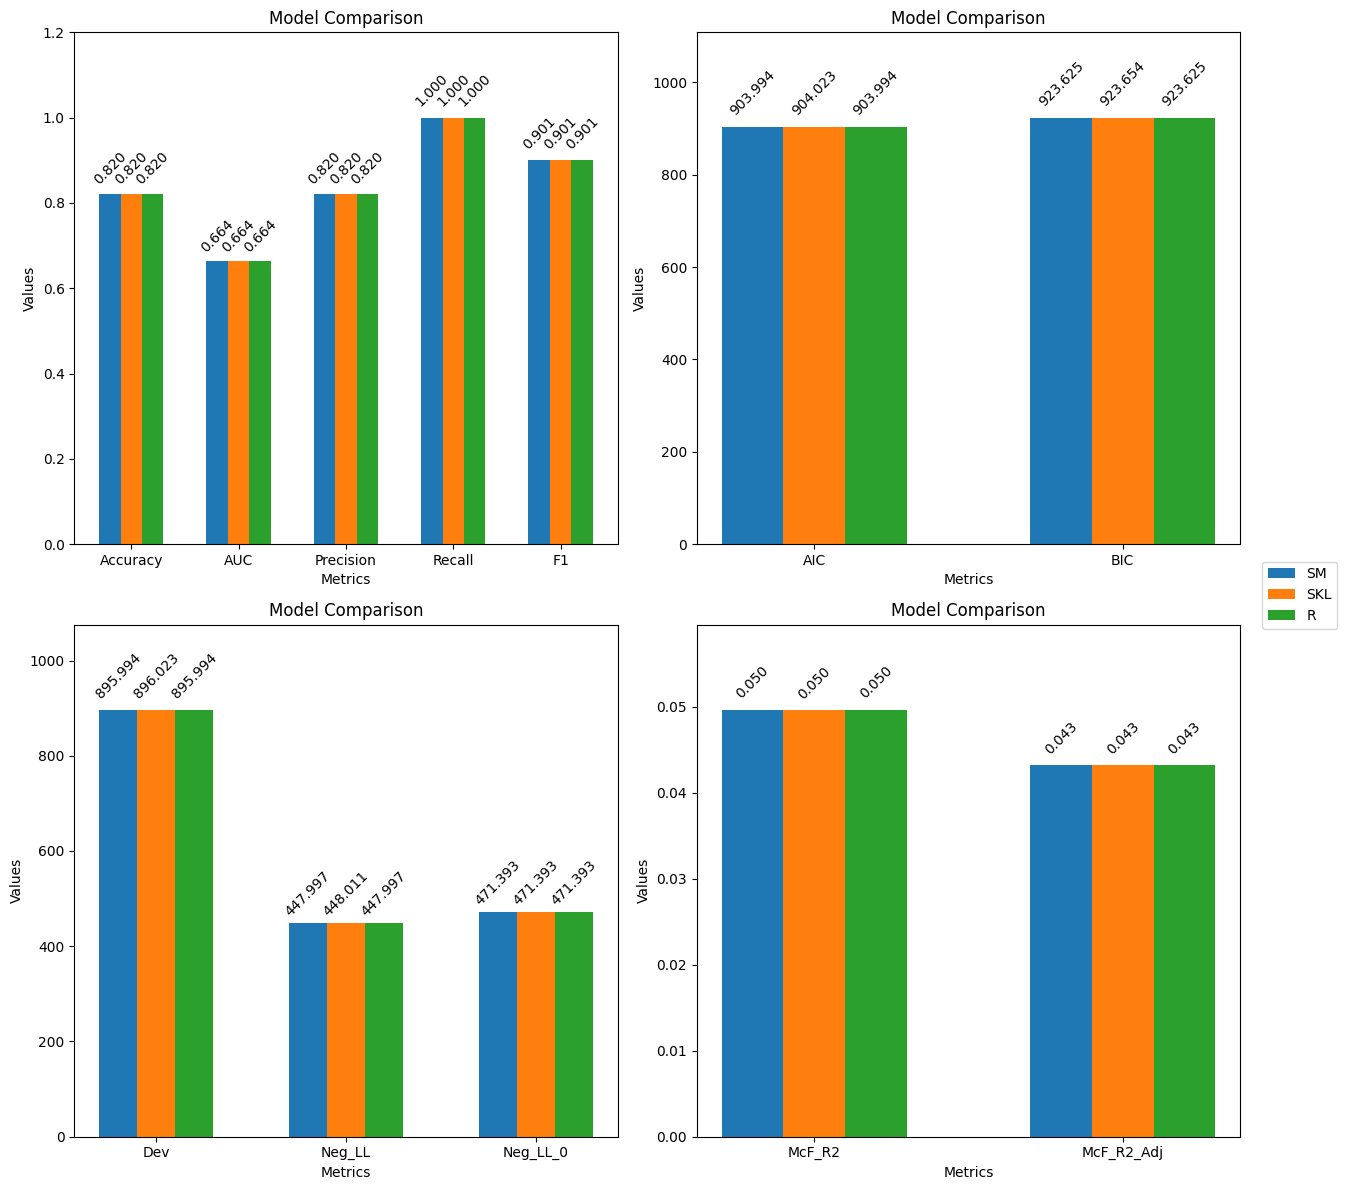

In [49]:
# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# Plot each group of metrics in a separate subplot
for ax, metric_group in zip(axes, metric_groups):
    bar_width = 0.2
    index = np.arange(len(metric_group))

    for i, model in enumerate(metrics_df_nll.columns):
        bars = ax.bar(index + i * bar_width, metrics_df_nll.loc[metric_group, model],
                      bar_width, label=model, color=colors[i])

        # Add text annotations
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2.0, height + 0.02 * height,
                    f'{height:.3f}', ha='center', va='bottom', rotation=45, fontsize=10)

    # Extend y-axis limits slightly for each subplot
    y_max = max(metrics_df_nll.loc[metric_group].max()) * 1.2
    ax.set_ylim(0, y_max)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Comparison')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(metric_group)

# Set up legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.9, 0.5))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

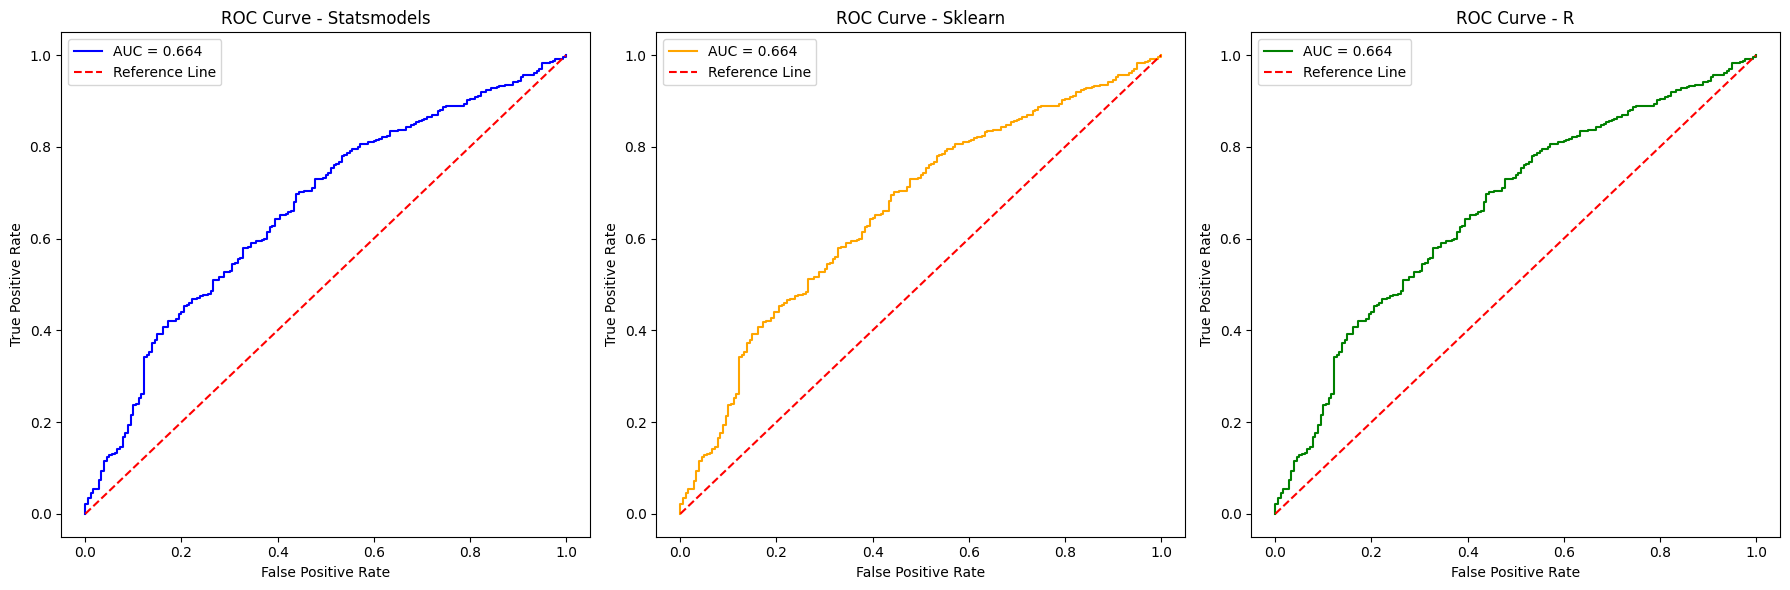

In [50]:
# Subplots for ROC plot comparison
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Statsmodels plot
fpr_sm, tpr_sm, _ = roc_curve(y, y_pred_proba_sm)
ax1.plot(fpr_sm, tpr_sm, color='blue', label=f'AUC = {auc_sm:.3f}')
ax1.plot([0, 1], [0, 1], color='red', linestyle='--', label='Reference Line')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Statsmodels')
ax1.legend()

# Sklearn plot
fpr_sk, tpr_sk, _ = roc_curve(y, y_pred_proba_sk)
ax2.plot(fpr_sk, tpr_sk, color='orange', label=f'AUC = {auc_sk:.3f}')
ax2.plot([0, 1], [0, 1], color='red', linestyle='--', label='Reference Line')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Sklearn')
ax2.legend()

# R plot
fpr_r, tpr_r, _ = roc_curve(y, np.array(ro.r('y_pred')))
ax3.plot(fpr_r, tpr_r, color='green', label=f'AUC = {auc_r:.3f}')
ax3.plot([0, 1], [0, 1], color='red', linestyle='--', label='Reference Line')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve - R')
ax3.legend()

plt.tight_layout()
plt.show()

# GLMM Workflow

## Python Imports

In [51]:
import os
import warnings
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
from rpy2.robjects.lib import grdevices
import rpy2.ipython.html

# Suppress warnings from rpy2
warnings.filterwarnings("ignore", category=FutureWarning, module="rpy2")
# Disable R warnings
rpy2_logger.setLevel(50)
# Enable R printing
rpy2.ipython.html.init_printing()
# Enable automatic DataFrame conversion
pandas2ri.activate()

## R Package Installation

In [52]:
# Function to install R packages if not already installed
def install_if_needed(package_name):
    try:
        importr(package_name)
    except PackageNotInstalledError:
        print(f"Installing {package_name}...")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
        with contextlib.redirect_stdout(None):
            utils.install_packages(package_name, quiet=True)

# Install required R packages
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
with contextlib.redirect_stdout(None):
    install_if_needed('stats')
    install_if_needed('ggplot2')
    install_if_needed('performance')
    install_if_needed('glmmTMB')
    install_if_needed('DHARMa')

## Generate the Data

In [53]:
# Generate the data
np.random.seed(123)
n_obs = 1000
n_groups = 50

X1 = np.random.normal(0, 1, n_obs)
X2 = np.random.normal(0, 1, n_obs)
group = np.repeat(range(n_groups), n_obs // n_groups)

true_beta = [1, 0.5, -0.5]
true_intercept = 1
mu = np.exp(true_intercept + true_beta[0] * X1 + true_beta[1] * X2 + np.random.normal(0, 0.5, n_obs))
y = np.random.negative_binomial(n=5, p=5/(5+mu))

# Create a DataFrame
data = pd.DataFrame({
    'group': group,
    'X1': X1,
    'X2': X2,
    'y': y
})
data.head()

,group,X1,X2,y
0,0,-1.085631,-0.748827,0
1,0,0.997345,0.567595,5
2,0,0.282978,0.718151,8
3,0,-1.506295,-0.999381,1
4,0,-0.578600,0.474898,0


## Fit the Model

In [54]:
# Convert to R DataFrame
r_data = ro.DataFrame(data)

# Add to global environment
ro.globalenv['r_data'] = r_data

# Fit the model in R and capture output
ro.r('''
# Load packages
library(stats)
library(ggplot2)
library(performance)
library(glmmTMB)
library(DHARMa)

# Fit the glmmTMB model
model <- glmmTMB(
  y ~ 1 + X1 + X2 + (1|group),
  data = r_data,
  family = nbinom2(link="log"),
  control = glmmTMBControl(optCtrl=list(iter.max=1e3, eval.max=1e3)),
  REML = FALSE
)

# Model summary
cat("Model Summary:\n")
print(summary(model))

# Get simulated scaled quantile residuals
simulated_residuals <- simulateResiduals(model, n=1000, quantreg=TRUE)
''')

# Get the model and simulated residuals from R
model = ro.globalenv['model']
simulated_residuals = ro.globalenv['simulated_residuals']

Model Summary:
 Family: nbinom2  ( log )
Formula:          y ~ 1 + X1 + X2 + (1 | group)
Data: r_data

     AIC      BIC   logLik deviance df.resid 
  4575.8   4600.3  -2282.9   4565.8      995 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 group  (Intercept) 0.001534 0.03917 
Number of obs: 1000, groups:  group, 50

Dispersion parameter for nbinom2 family (): 2.06 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.15821    0.03163   36.61   <2e-16 ***
X1           0.98778    0.03246   30.43   <2e-16 ***
X2           0.47342    0.03162   14.97   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Evaluate the Model

In [55]:
# Calculate metrics using fitted model
ro.r('''
mse <- mse(model)
rmse <- rmse(model)

aic <- AIC(model)
bic <- BIC(model)

r2_marginal <- r2_nakagawa(model)$R2_marginal
r2_conditional <- r2_nakagawa(model)$R2_conditional

icc_output <- capture.output(icc(model))
''')

# Extract metric values from R
mse = ro.globalenv['mse'][0]
rmse = ro.globalenv['rmse'][0]

aic = ro.globalenv['aic'][0]
bic = ro.globalenv['bic'][0]

r2_marginal = ro.globalenv['r2_marginal'][0]
r2_conditional = ro.globalenv['r2_conditional'][0]

# Extract ICC values from the captured output
icc_lines = [line for line in ro.globalenv['icc_output'] if 'ICC' in line]
icc_values = {}
for line in icc_lines:
    key, value = line.split(':')
    icc_values[key.strip()] = float(value.strip())

In [56]:
# Create metrics DataFrame
metrics_df = pd.DataFrame({
    'Metric': [
        'MSE', 'RMSE',
        'AIC', 'BIC',
        'R2 (marginal)', 'R2 (conditional)'
    ] + list(icc_values.keys()),
    'Value': [
        mse, rmse,
        aic, bic,
        r2_marginal, r2_conditional
    ] + list(icc_values.values())
})

print("Metrics DataFrame:")
print(metrics_df)

Metrics DataFrame:
             Metric        Value
0               MSE    54.079030
1              RMSE     7.353845
2               AIC  4575.792889
3               BIC  4600.331666
4     R2 (marginal)     0.690784
5  R2 (conditional)     0.691701
6      Adjusted ICC     0.003000
7    Unadjusted ICC     0.001000


In [57]:
# Performance diagnostics
perf_diagnostics = [
    ("check_singularity", "check_singularity(model)"),
    ("check_collinearity", "check_collinearity(model)"),
    ("check_overdispersion", "check_overdispersion(model)"),
    ("check_zeroinflation", "check_zeroinflation(model)")
]

# DHARMa diagnostics
dharma_diagnostics = [
    ("plotFunction", "plot(simulated_residuals)"),
    ("plotQQunif", "plotQQunif(simulated_residuals)"),
    ("plotResiduals", "plotResiduals(simulated_residuals, quantreg=TRUE)"),
    ("testUniformity", "testUniformity(simulated_residuals)"),
    ("testDispersion", "testDispersion(simulated_residuals)"),
    ("testOutliers", "testOutliers(simulated_residuals)"),
    ("testZeroInflation", "testZeroInflation(simulated_residuals)")
]


check_singularity output:
[1] FALSE

check_collinearity output:
# Check for Multicollinearity

Low Correlation

 Term  VIF   VIF 95% CI Increased SE Tolerance Tolerance 95% CI
   X1 1.01 [1.00, 4.19]         1.01      0.99     [0.24, 1.00]
   X2 1.01 [1.00, 4.19]         1.01      0.99     [0.24, 1.00]

check_overdispersion output:
# Overdispersion test

 dispersion ratio = 1.213
          p-value = 0.328


check_zeroinflation output:
# Check for zero-inflation

   Observed zeros: 208
  Predicted zeros: 216
            Ratio: 1.04


plotFunction output:
NULL
Plot file: plotFunction.png


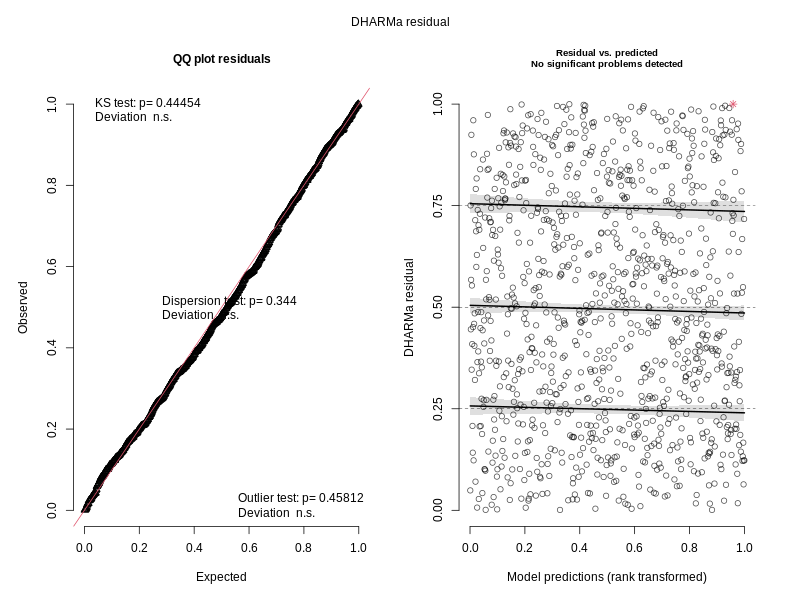


plotQQunif output:
$rect
$rect$w
[1] 0.2461729

$rect$h
[1] 0.09979466

$rect$left
[1] 0.3769136

$rect$top
[1] 0.5498973


$text
$text$x
[1] 0.4097366 0.4097366

$text$y
[1] 0.5166324 0.4833676


Plot file: plotQQunif.png


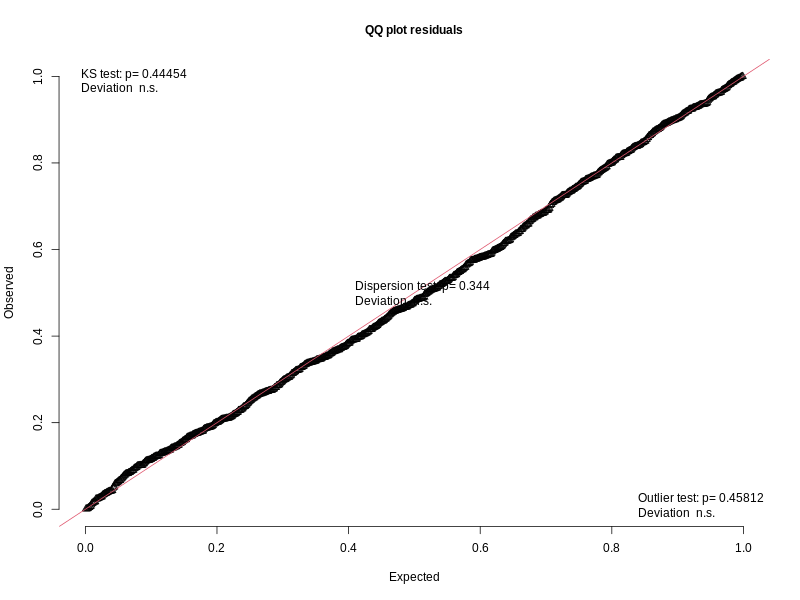


plotResiduals output:

	Test for location of quantiles via qgam

data:  simulationOutput
p-value = 0.8862
alternative hypothesis: both

Plot file: plotResiduals.png


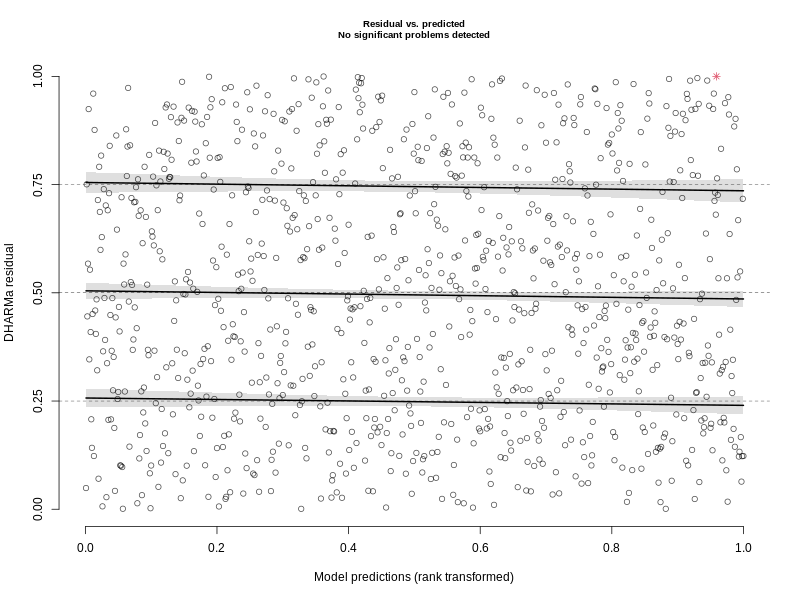


testUniformity output:

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  simulationOutput$scaledResiduals
D = 0.027317, p-value = 0.4445
alternative hypothesis: two-sided

Plot file: testUniformity.png


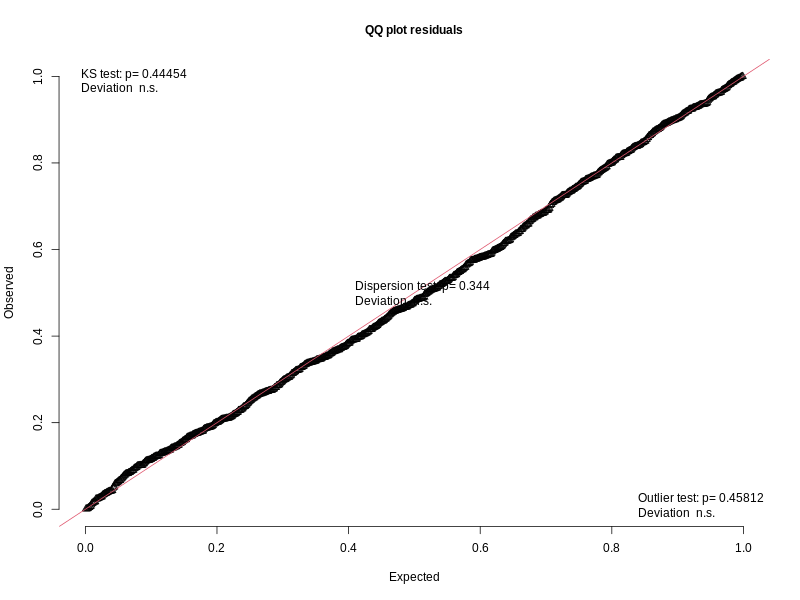


testDispersion output:

	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 1.1872, p-value = 0.344
alternative hypothesis: two.sided

Plot file: testDispersion.png


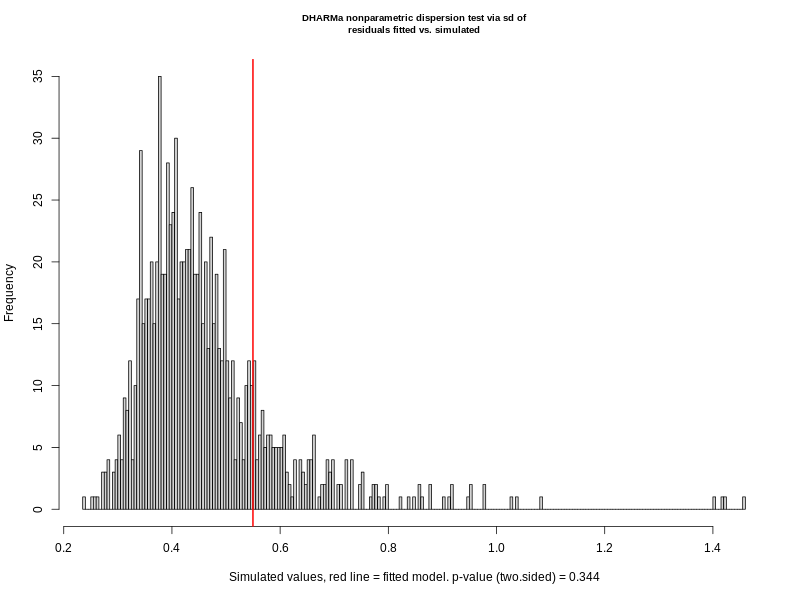


testOutliers output:

	DHARMa outlier test based on exact binomial test with approximate
	expectations

data:  simulated_residuals
outliers at both margin(s) = 3, observations = 1000, p-value = 0.4581
alternative hypothesis: true probability of success is not equal to 0.001998002
95 percent confidence interval:
 0.0006190999 0.0087420232
sample estimates:
frequency of outliers (expected: 0.001998001998002 ) 
                                               0.003 

Plot file: testOutliers.png


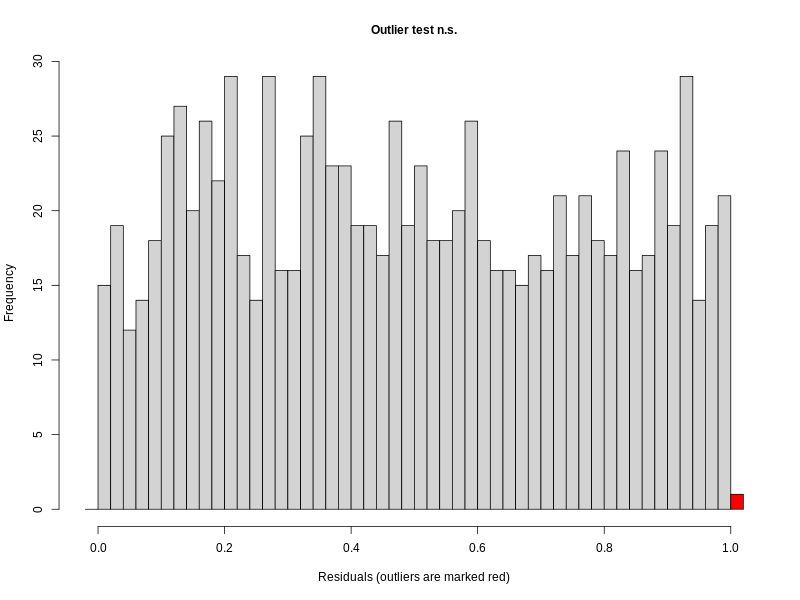


testZeroInflation output:

	DHARMa zero-inflation test via comparison to expected zeros with
	simulation under H0 = fitted model

data:  simulationOutput
ratioObsSim = 0.96486, p-value = 0.534
alternative hypothesis: two.sided

Plot file: testZeroInflation.png


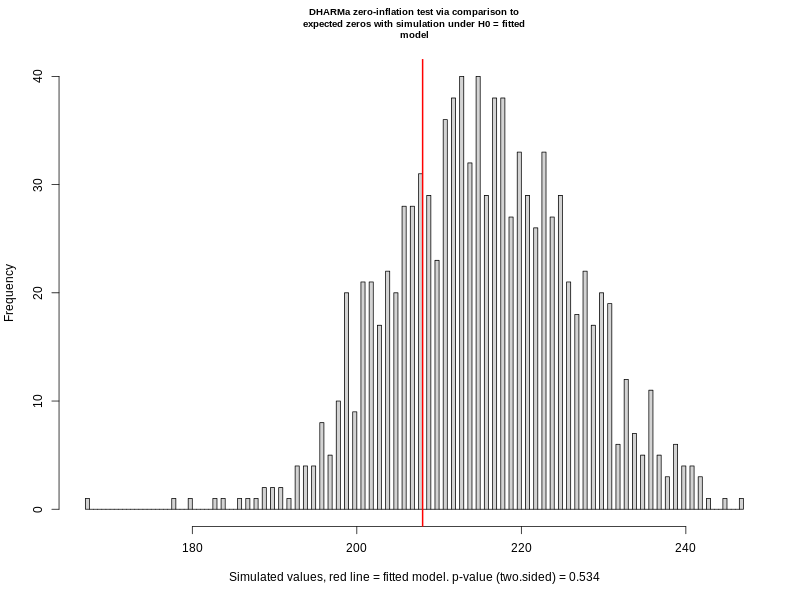

In [58]:
from IPython.display import Image, display

# Run diagnostics
for diag_name, diag_code in perf_diagnostics:
    ro.r(f'''
    cat("\\n{diag_name} output:\\n")
    print({diag_code})
    ''')

for plot_name, plot_code in dharma_diagnostics:
    ro.r(f'''
    png("{plot_name}.png", width=800, height=600)
    cat("\\n{plot_name} output:\\n")
    print({plot_code})
    dev.off()
    ''')

    # Print plot file name
    print(f"Plot file: {plot_name}.png")

    # Display the plot
    display(Image(filename=f'{plot_name}.png'))